# Introduction

Hello there, This analysis notebook aims to answer some questions I find<br>
interesting about the numbers & stats behind popular movies. Wish you find the<br>
results of the analysis intersting & hopefully get a better understanding of the<br>
mainstream movie industry as a whole.


Here are the stuff we are inspecting in this notebook.
- **[Q1](#q1)**. Profitable producers
- **[Q2](#q2)**. Profitable genres
- **[Q3](#q3)**. Pobular movies era
- **[Q4](#q4)**. Genres quality trends
- **[Q5](#q5)**. Sequel rating change
- **[BONUS](#bonus)**. Descriptions wordclouds

> **NOTE:** the movies used in the analysis are the top 2000 movies in vote count<br>
> on TMDB, in other words the movies here are the **most voted** on TMDB.

# Setting up

In [1]:
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import requests
import datetime
import duckdb
import PIL
import cv2
import os

from wordcloud import (
    ImageColorGenerator,
    WordCloud,
    STOPWORDS
)

In [2]:
FONT_PATH="../fonts/Inter_24pt-Regular.ttf"
FONT = 25
PAD = 25

if os.path.isfile(FONT_PATH):
    fm.fontManager.addfont(FONT_PATH)
    prop = fm.FontProperties(fname=FONT_PATH)
    plt.rcParams['font.family'] = prop.get_name()

In [3]:
df = pd.read_csv("../data/movies_clean.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            2463 non-null   int64  
 1   id                    2463 non-null   int64  
 2   imdb_id               2463 non-null   object 
 3   release_date          2463 non-null   object 
 4   title                 2463 non-null   object 
 5   collection            991 non-null    object 
 6   overview              2463 non-null   object 
 7   tagline               2387 non-null   object 
 8   language              2463 non-null   object 
 9   runtime               2463 non-null   int64  
 10  revenue               2360 non-null   float64
 11  budget                2368 non-null   float64
 12  vote_avg              2463 non-null   float64
 13  vote_count            2463 non-null   int64  
 14  genres                2463 non-null   object 
 15  production_countries 

# The analysis

### **Q1**. Profitable producers

Let's start by looking at best & worst production companies at generating large<br>
net-profit with small budget which might help anyone looking to invest in any<br>
any of those production companies.

This is simply caclulated by represnting the ratio between average budget &<br>
average box office net-profit for the movies the production company has made.
<br>

> **NOTE**: DON'T use any output of this analysis for decesions regarding<br>
 investments, or money in general, You have been warned.

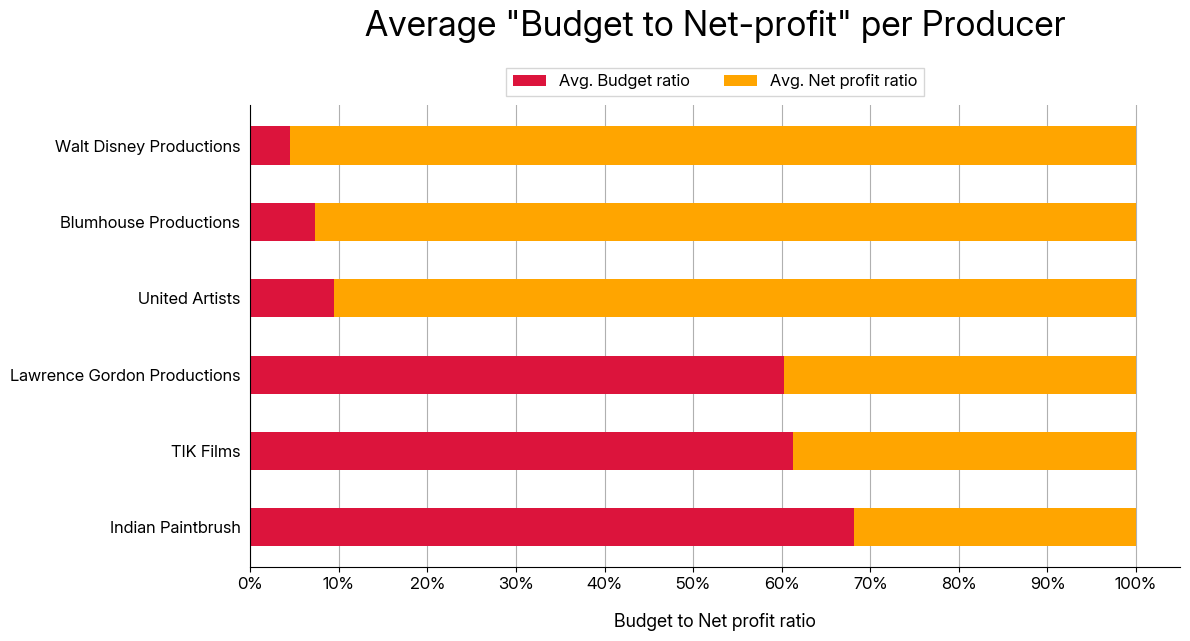

In [5]:
data = duckdb.sql("""
    SELECT producer,
           MEDIAN(budget_to_revenue) AS budget_to_revenue, -- Median is the best for this case
           SUM(occurance) AS occurances,
    FROM (
        SELECT
            UNNEST(SPLIT(production_companies, ', ')) AS producer,
            budget / revenue AS budget_to_revenue,
            1 AS occurance
        FROM df
        WHERE ABS(budget_z_score)  < 3.5 AND -- We don't have to be too strict with outliers
              ABS(revenue_z_score) < 3.5
    )
    GROUP BY producer
    HAVING occurances >= 10 -- Making sure we don't get small producers
    ORDER BY budget_to_revenue DESC -- From most succeful to least succeful
""").df()

data = pd.concat([data.iloc[:3], data.iloc[-3:]])

fig, ax = plt.subplots()

ax.barh(
    data["producer"], data["budget_to_revenue"],
    zorder=2,
    height=0.5,
    color="crimson",
    label="Avg. Budget ratio"
)

ax.barh(
    data["producer"], 1-data["budget_to_revenue"],
    left=data["budget_to_revenue"],
    zorder=2,
    height=0.5,
    color="orange",
    label="Avg. Net profit ratio" 
)

ax.spines[['right', 'top']].set_visible(False)
ax.grid('off', axis='x', zorder=0)
ax.legend(
    bbox_to_anchor=(0.5, 1.1, 0., 0.),
    loc="upper center", ncols=2,
    fancybox=False, fontsize=12
)

ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.yaxis.set_ticks_position('none') 
ax.xaxis.set_major_formatter(
    ticker.FixedFormatter([str(x*10) + "%" for x in range(0, 11)])
)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Budget to Net profit ratio", fontsize=13, labelpad=15)
ax.set_title("Average \"Budget to Net-profit\" per Producer", fontsize=25, pad=50)

fig.set_size_inches(12, 6)
plt.savefig("../imgs/profitable_producer.jpg")
plt.show()

I think that people who watch the said production companies within the<br>
chart can relate to what it's saying. I just can't explain it more without<br>
a long paragraph which I won't do.

### **Q2**. Profitable genres

Now we'll look at which genres generate high box office net-profit with the<br>
least budget. By showing thier budget to net-profit percentage.

This question will help us understand more about the film-making industry.

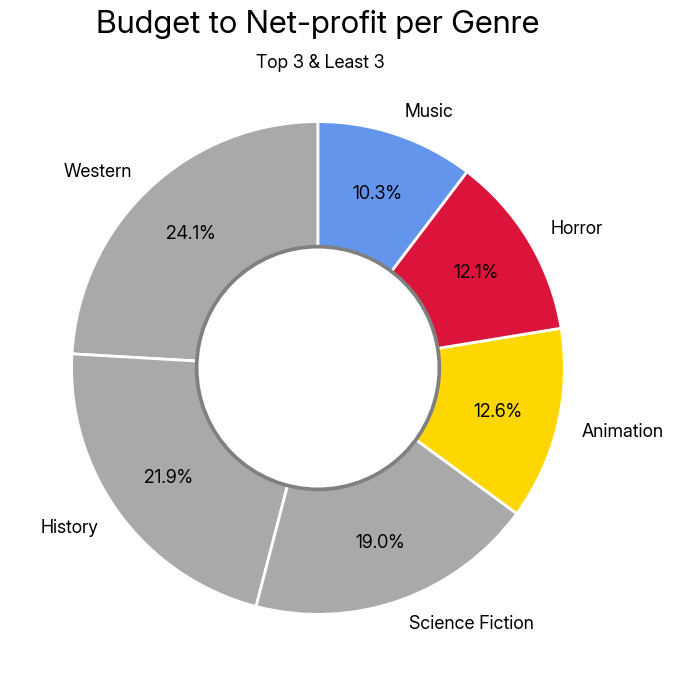

In [6]:
data = duckdb.sql("""
    SELECT genre,
    MEDIAN(budget_to_revenue) AS budget_to_revenue,
    SUM(occurance) AS occurances
    FROM (
        SELECT UNNEST(SPLIT(genres, ', ')) AS genre,
            budget / revenue AS budget_to_revenue,
            1 AS occurance
        FROM df
        WHERE ABS(budget_z_score)  < 3 AND
              ABS(revenue_z_score) < 3
    )
    GROUP BY genre
    HAVING occurances > 20
    ORDER BY budget_to_revenue DESC
""").df()

data = pd.concat([data.iloc[:3], data.iloc[-3:]])

fig, ax = plt.subplots()

colors = ["darkgrey"]*3 + [
    "gold", # animation
    "crimson", # horror
    "cornflowerblue" # music
]

ax.pie(
    data["budget_to_revenue"],
    labels=data["genre"],
    autopct='%2.1f%%',
    labeldistance=1.1,
    startangle=90,
    pctdistance=0.75,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2},
    colors=colors,
    textprops={'fontsize':13}
)

grey_circle = plt.Circle((0, 0), 0.5, fc='grey')
white_circle = plt.Circle((0, 0), 0.485, fc='white')
ax.add_artist(grey_circle)
ax.add_artist(white_circle)

ax.set_title('Budget to Net-profit per Genre', fontsize= 23, pad=20)
ax.annotate(xy=(-0.25, 1.22), text='Top 3 & Least 3', fontsize=13)

fig.set_size_inches(10, 8)

plt.show()

Wow, this chart actually makes a lot of sense; History, Science Fiction & Western<br>
movies can be really expensive to produce which highers thier *"budget to revenue"*.<br>
Where Horror & Music movies are relativly cheaper & able to produce a large revenue.

The unexpected is that Animation genre has one of the lowest *"budget to revenue"*<br>
though known to be one of the most expensive genres to produce, my guess of why<br> that
is true, is because production companies do really good marketing and won't risk<br>
making an animation movie if not 100% it'll succeed.

### **Q3**. Pobular movies era

In this chart I aim to find the movies era with the most total votes of all time<br>
on TMDB, in otherwords which movies era did reviewers review the most.<br>
Indicating us what era produced the pobular movies.

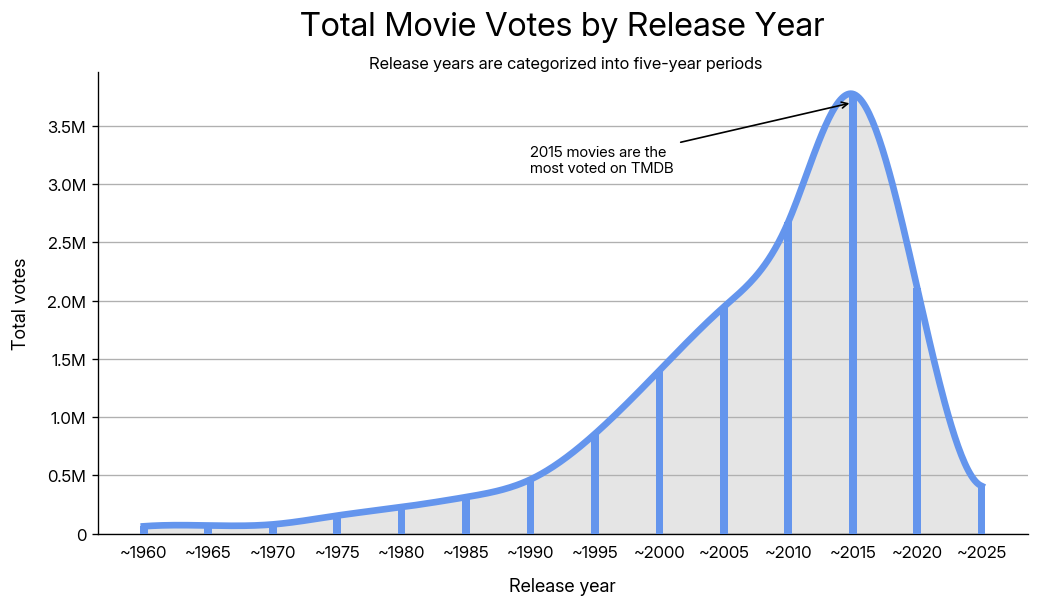

In [6]:
data = duckdb.sql("""
   SELECT 
       SUM(vote_count) AS vote_count,
       COUNT(id) AS occurances,
       ROUND(CAST(SPLIT(release_date, '-')[1] AS INTEGER)/5)*5 AS release_year,
   FROM df
   GROUP BY 
       ROUND(CAST(SPLIT(release_date, '-')[1] AS INTEGER)/5)*5
   HAVING occurances > 10
   ORDER BY release_year ASC
""").df()
# TODO: make the chart smoother

fig, ax = plt.subplots()

spline = interp1d(data["release_year"], data["vote_count"], kind="cubic")
new_x  = np.linspace(
    data["release_year"].min(), data["release_year"].max(), 500
)

ax.bar(
    x=data["release_year"],
    height=data["vote_count"],
    width=0.6,
    color="cornflowerblue",
    zorder=3
)

ax.plot(
    new_x,
    spline(new_x),
    linewidth=4,
    color="cornflowerblue",
    zorder=4
)
# 
ax.fill_between(
    new_x,
    spline(new_x),
    color="darkgrey",
    alpha=0.3
)

ax.set_xticks(data["release_year"], data["release_year"].apply(
    lambda x: f"~{x:.0f}"
))
ax.xaxis.set_ticks_position('none') 

ax.spines[['right', 'top']].set_visible(False)
ax.grid('off', axis='y', zorder=0)
ax.yaxis.set_major_formatter(
    lambda x, pos: f"{(x/1_000_000):.1f}M" if x != 0 else 0
)

ax.set_ylabel("Total votes", labelpad=10, fontsize=11)
ax.set_xlabel("Release year", labelpad=10, fontsize=11)

ax.annotate(
    xy=(1977.5, 4e6), text="Release years are categorized into five-year periods",
    fontsize=10, annotation_clip=False
)

ax.annotate(
    "2015 movies are the\nmost voted on TMDB",
    xy=(2015, 3.7e6), xytext=(1990, 3.1e6), zorder=999, # sweetspot ;)
    arrowprops=dict( arrowstyle="->", ), fontsize=9
)

ax.set_title("Total Movie Votes by Release Year", fontsize=20, pad=22)

fig.set_size_inches(10, 5)
fig.set_dpi(120) 

plt.show()

We can see a few nice trends here are the most noteicable ones:
- 2013~2017 is the peak of total votes
- Votes fell drastically around 2020 & 2025
- Votes for movies sky rocketed after ~1995

### **Q4**. Genres quality trends

This is the most "cliché" question here questioning: Are movies across different<br>
genres still the same quality *-indicated by rating-* as the good old days? or have<br>
it change to worse?<br>

The latter for some reason is usually the answer.

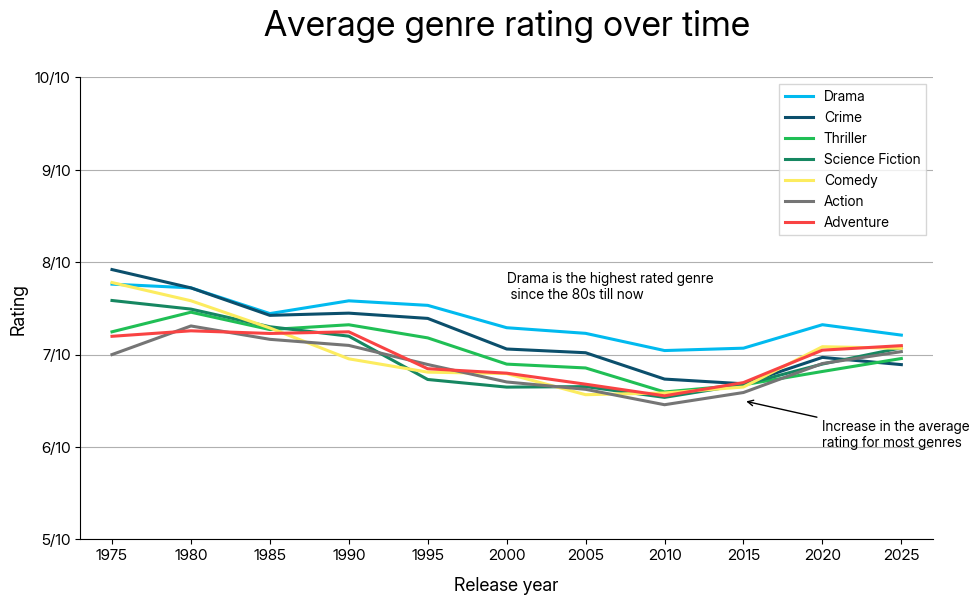

In [5]:
data = duckdb.sql("""
    SELECT
        ROUND(CAST(SPLIT(release_date, '-')[1] AS INTEGER)/5)*5 AS release_year,
        AVG(df.vote_avg) AS vote_avg,
        g1.genre
    FROM df
    
    CROSS JOIN UNNEST(SPLIT(df.genres, ', ')) AS g1(genre)
    
    JOIN (
        SELECT g2.genre
        FROM df
        CROSS JOIN UNNEST(SPLIT(genres, ', ')) AS g2(genre)
        GROUP BY g2.genre
        ORDER BY COUNT(*) DESC
        LIMIT 7
    ) AS common_genres
    
    ON g1.genre = common_genres.genre -- this query was assisted with an LLM
    WHERE release_year > 1970
    GROUP BY release_year, g1.genre
    ORDER BY release_year, vote_avg DESC;
""").df()

fig, ax = plt.subplots()

# HARDCODING the order of the genre so the legend can be more readable
genres = set(data["genre"].unique())

if set(["Comedy", "Crime", "Adventure",
       "Science Fiction", "Drama",
       "Thriller", "Action"]) == genres:
    genres = ["Drama", "Crime", "Thriller", "Science Fiction",
              "Comedy", "Action", "Adventure"]

colors = ["#01BAEF", "#0B4F6C", "#20BF55", "#168761",
          "#FCEC5F", "#757575", "#F94343"]

for i, genre in enumerate(genres):
    genre_data = data.loc[data["genre"] == genre]
    ax.plot(
        genre_data["release_year"],
        genre_data["vote_avg"],
        label=genre,
        linewidth=2.2,
        color=colors[i]
    )

ax.legend(fancybox=False)

ax.set_xticks(np.arange(
    data["release_year"].min(),
    data["release_year"].max()+5, 5
))
ax.yaxis.set_major_formatter(
    lambda x, pos: f"{x:.0f}/10"
)

ax.set_xlim(
    xmin=data["release_year"].min() - 2,
    xmax=data["release_year"].max() + 2
)
ax.set_ylim(ymin=5, ymax=10)

ax.spines[["top", "right"]].set_visible(False)
ax.grid("off", axis="y", zorder=0)

ax.tick_params(axis='both', which='major', labelsize=11)

ax.set_xlabel("Release year", labelpad=10, fontsize= 13)
ax.set_ylabel("Rating", labelpad=5, fontsize= 13)

ax.annotate(
    "Increase in the average\nrating for most genres",
    xy=(2015, 6.5), xytext=(2020, 6),
    arrowprops=dict(
        arrowstyle="->",
    ))

ax.annotate(
    "Drama is the highest rated genre\n since the 80s till now",
    xy=(2000, 7.6)
)

ax.set_title("Average genre rating over time", fontsize=FONT, pad=30)

fig.set_size_inches(11, 6)
plt.show()

There are 4 notable things we can infer with ease from this chart:
1. There was drop in rating across every genre around 1985
2. Drama followed by Crime & Thriller were the most to survive the 1985 rating<br> drop
3. Drama genre is the highest rated genre overall with a decent positive edge
4. Unexpctedly there was an increase in the rating across all genres around 2015

### **Q5**. Sequel rating change

How much does the rating change across a movie sequel in average ?<br>
I think we all know the result of this beforehand, but let's see what the data has to<br>
say.

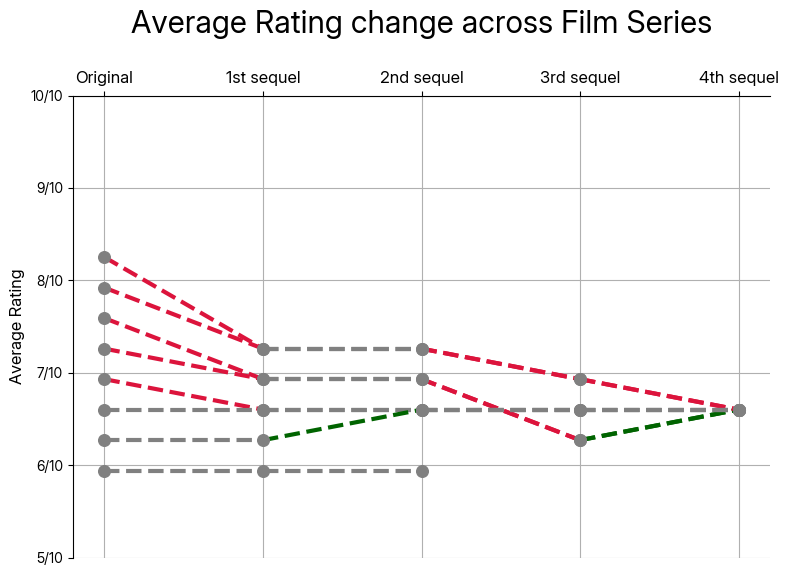

In [6]:
data = duckdb.sql("""
    WITH vote_avgs AS (
        SELECT
            SUM(CASE WHEN seq = 1 THEN vote_avg ELSE NULL END) AS vote_avg_1,
            SUM(CASE WHEN seq = 2 THEN vote_avg ELSE NULL END) AS vote_avg_2,
            SUM(CASE WHEN seq = 3 THEN vote_avg ELSE NULL END) AS vote_avg_3,
            SUM(CASE WHEN seq = 4 THEN vote_avg ELSE NULL END) AS vote_avg_4,
            SUM(CASE WHEN seq = 5 THEN vote_avg ELSE NULL END) AS vote_avg_5,
            COUNT(*) OVER (PARTITION BY vote_avg_1) AS vote_avg_1_freq,
        FROM (
            SELECT 
                collection,
                ROUND(vote_avg / 0.33)* 0.33            AS vote_avg, -- 0.333 would cause rounding errors
                CAST(release_date AS DATE)              AS release_date,
                COUNT(*) OVER (PARTITION BY collection) AS seq_len,
                ROW_NUMBER() OVER (
                    PARTITION BY collection ORDER BY release_date
                )                                       AS seq
            FROM df
        )
        WHERE seq_len > 1
        GROUP BY collection
    ),

    seq_1_vote_avgs AS (
        SELECT
            -- g stands for Grouped
            vote_avg_1 AS vote_avg_1_g,
            COUNT(*) OVER (PARTITION BY vote_avg_1_g) AS vote_occurances,
            ROUND(AVG(vote_avg_2) OVER (PARTITION BY vote_avg_1_g) / 0.33) * 0.33 AS vote_avg_2_g,
            vote_avg_3,
            vote_avg_4,
            vote_avg_5,
        FROM vote_avgs
        WHERE vote_avg_1_freq > 5
    ),

    seq_2_vote_avgs AS (
        SELECT 
            vote_avg_1_g,
            vote_avg_2_g,
            ROUND(AVG(vote_avg_3) OVER (PARTITION BY vote_avg_2_g) / 0.33) * 0.33 AS vote_avg_3_g,
            vote_avg_4,
            vote_avg_5,
        FROM seq_1_vote_avgs
    ),

    seq_3_vote_avgs AS (
        SELECT 
            vote_avg_1_g,
            vote_avg_2_g,
            vote_avg_3_g,
            ROUND(AVG(vote_avg_4) OVER (PARTITION BY vote_avg_3_g) / 0.33) * 0.33 AS vote_avg_4_g,
            vote_avg_5,
        FROM seq_2_vote_avgs
    ),

    final_vote_avgs AS (
        SELECT 
            vote_avg_1_g,
            vote_avg_2_g,
            vote_avg_3_g,
            vote_avg_4_g,
            ROUND(AVG(vote_avg_5) OVER (PARTITION BY vote_avg_4_g) / 0.33) * 0.33 AS vote_avg_5_g,
        FROM seq_3_vote_avgs
    )
    
    SELECT DISTINCT * 
    FROM final_vote_avgs
""").df()

fig, ax = plt.subplots()

for i in range(len(data.columns)):
    for j in range(len(data)):

        ax.scatter(
            i+1, data.iloc[j,i],
            s=70, c="grey", zorder=5
        )
        
        if i == len(data.columns)-1:
            continue

        if   data.iloc[j,i+1] > data.iloc[j,i]: color = "darkgreen"
        elif data.iloc[j,i+1] < data.iloc[j,i]: color = "crimson"
        else:                                   color = "grey"
        
        ax.plot(
            [i+1, i+2], # for formatting purposes
            [data.iloc[j,i], data.iloc[j,i+1]],
            "--", linewidth=3, color=color, zorder=4,
        )

ax.spines[["right", "bottom"]].set_visible(False)
ax.grid("off", axis="x", zorder=-1)
ax.grid("off", axis="y", zorder=-1)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

ax.set_xticks(
    np.arange(1, 6),
    ["Original", "1st sequel", "2nd sequel", "3rd sequel", "4th sequel"],
    fontsize=12
)

ax.yaxis.set_major_formatter(
    lambda x, pos: f"{x:.0f}/10"
)
ax.set_ylim(5, 10)
ax.set_title("Average Rating change across Film Series", pad=45, fontsize=22)
ax.set_ylabel("Average Rating", fontsize=12)

fig.set_size_inches(9, 6)
plt.show()

That was expected, movies usually get worse in quality throw the movies series<br>
leading to worse rating, what's kind of notable is how the transition between<br>
the second & third sequel in average doesn't change the rating.<br>

### **Bonus**. Descriptions wordcloud

Let's finish off with a little fun visual showing us frequent words used in movies<br>
movies descriptions across different genres.

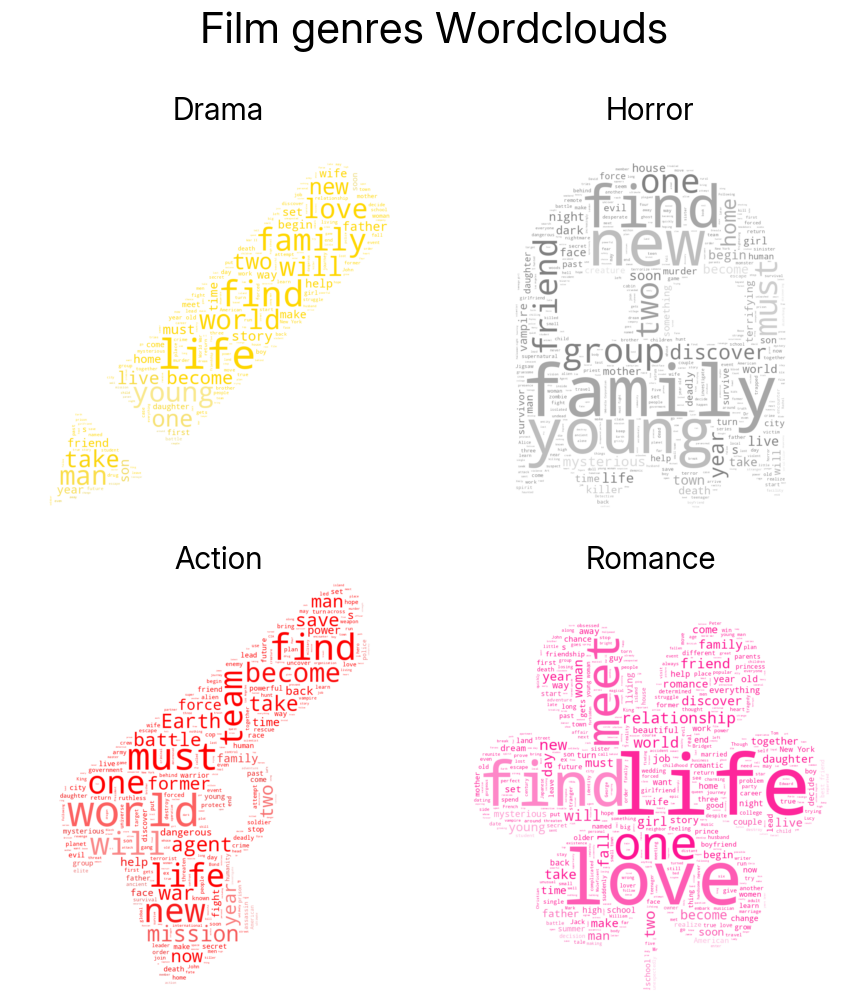

In [18]:
data = duckdb.sql("""
    SELECT genre,
        STRING_AGG(overview, ' ') AS concated_overviews
    FROM (
        SELECT overview, UNNEST(SPLIT(genres, ', ')) AS genre
        FROM df
    )
    WHERE genre IN ('Drama', 'Horror', 'Action', 'Romance')
    GROUP BY genre
    ORDER BY CASE
        WHEN genre = 'Drama' THEN 1
        WHEN genre = 'Horror' THEN 2
        WHEN genre = 'Action' THEN 3
        WHEN genre = 'Romance' THEN 4
    END ASC
""").df()

fig, axes = plt.subplots(nrows=2, ncols=2)
axes = axes.flatten()

mask_paths = [
    "../imgs/assets/pen.png",
    "../imgs/assets/ghost.png",
    "../imgs/assets/gun.png",
    "../imgs/assets/flower.png",
]

colors = [
    "gold",
    "grey",
    "red",
    "deeppink"
]

for i in range(axes.shape[0]):
    mask_img = cv2.imread(mask_paths[i])
    
    # coloring the mask
    black_pixels = np.all(mask_img == (0, 0, 0), axis=2)
    mask_img[black_pixels] = np.array(mcolors.to_rgb(colors[i]))*255

    color_func = ImageColorGenerator(mask_img)

    stopwords = set(STOPWORDS)
    stopwords.add("int")
    stopwords.add("ext")

    wc = WordCloud(
        max_words=1000,
        mask=mask_img,
        stopwords=stopwords,
        margin=10,
        random_state=1,
        background_color="white"
    ).generate(data.iloc[i,1])
    
    axes[i].imshow(
        wc.recolor(color_func=color_func),
        interpolation="bilinear"
    )
    axes[i].axis("off")
    axes[i].set_title(f"{data.iloc[i,0]}", fontsize=20)

fig.suptitle("Film genres Wordclouds",fontsize=28, y=1.02)

fig.set_size_inches(8, 9)
fig.set_dpi(110)
fig.tight_layout()

plt.show()

This chart has **0** practical uses but it has an eye-pleasent & fun look which<br>
is enough.

# Summary

If you don't want to read all of the above here is a summary of the findings ;)

- Q2: Profitable genres:<br>
History, Science Fiction & Western movies can be really expensive to produce<br>
which highers thier *"budget to revenue"*, Where Horror & Music movies are<br>
relativly cheaper & able to produce a large revenue.
 
- Q3: Pobular movies era:<br>
Around 2015 was when most voted movies -on TMDB- were released but fill<br>
drastically after that.

- Q4: Genres quality trends:<br>
There was a significant drop in rating across every genre around 1985 that<br>
continued till around 2015 where it was starting to get better again.

- Q5: Sequel rating change:<br>
Film sequels tend to diverge to worse & most of them diverged after 4 sequels<br>
to rating of about **~6.5**